In [2]:
import os
import sys

import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
from statsmodels.stats.weightstats import ztest


sys.path.append(os.path.dirname("../src"))

from src.clean_data import get_clean_logs
from src.utils import merge_series_by_index
from src.testing import z_test_conversion, bootstrap_pvalue

In [66]:
rng = RandomState(MT19937(SeedSequence(123)))

In [68]:
type(rng)

numpy.random.mtrand.RandomState

In [4]:
clean_logs = get_clean_logs()

In [5]:
clean_logs.head()

,datetime,user_id,variant,city,event_type,revenue
0,2021-08-01 00:00:39,786179591,B,rome,property_view,NaN
1,2021-08-01 00:02:29,790889727,A,rome,property_view,NaN
2,2021-08-01 00:06:27,869904661,B,madrid,property_view,NaN
3,2021-08-01 00:06:29,835833313,B,rome,property_favorite_added,NaN
4,2021-08-01 00:11:51,950822873,A,madrid,property_view,NaN


In [5]:
experiment = merge_series_by_index(
    clean_logs.drop_duplicates(subset=["user_id"])["variant"]
    .value_counts()
    .rename("tot_users"),
    clean_logs.loc[clean_logs["event_type"] == "booking_request", "variant"]
    .value_counts()
    .rename("tot_bookings"),
    clean_logs.groupby("variant")
    .agg(tot_revenue=("revenue", "sum"))
    .reset_index()
    .set_index("variant")["tot_revenue"],
)

In [6]:
2*(1 - st.norm.cdf(abs(-3.0877)))

0.0020171198854121997

In [7]:
experiment.to_dict("index")

{'B': {'tot_users': 812,
  'tot_bookings': 153,
  'tot_revenue': 50706.19397225155},
 'A': {'tot_users': 806,
  'tot_bookings': 203,
  'tot_revenue': 39050.62011896709}}

In [8]:
experiment.reset_index().rename(columns={"index": "variant"})

,variant,tot_users,tot_bookings,tot_revenue
0,B,812,153,50706.193972
1,A,806,203,39050.620119


In [9]:
experiment["cvr"] = experiment["tot_bookings"] / experiment["tot_users"]
experiment["rpu"] = experiment["tot_revenue"] / experiment["tot_users"]

In [10]:
experiment

,tot_users,tot_bookings,tot_revenue,cvr,rpu
B,812,153,50706.193972,0.188424,62.446052
A,806,203,39050.620119,0.251861,48.449901


In [11]:
experiment.reset_index()

,index,tot_users,tot_bookings,tot_revenue,cvr,rpu
0,B,812,153,50706.193972,0.188424,62.446052
1,A,806,203,39050.620119,0.251861,48.449901


In [29]:
revenue_df = (
    clean_logs.fillna({"revenue": 0})
    .groupby("user_id")
    .agg(
        revenue=("revenue", "sum"), variant=("variant", "first"), city=("city", "first")
    )
)


In [30]:
revenue_df["conversion"] = (revenue_df["revenue"] > 0).astype(float)

In [14]:
revenue_df.head()

,revenue,variant,conversion
user_id,,,
100484273,0.000000,B,0.0
101079600,203.522684,A,1.0
101167498,0.000000,A,0.0
101196311,0.000000,B,0.0
101428127,0.000000,A,0.0


In [15]:
group_A = revenue_df[revenue_df["variant"] == "A"]["conversion"]
group_B = revenue_df[revenue_df["variant"] == "B"]["conversion"]
ttest = ztest(group_A, group_B, alternative="two-sided")
ttest[1]*100

0.11191063201347609

In [16]:
ttest = ztest(group_A, group_B, alternative="larger")
2*ttest[1]*100

0.11191063201347609

In [17]:
mean_id = (
    revenue_df.reset_index()
    .assign(last_digit=lambda x: x["user_id"].str[-1])
    .groupby(["last_digit", "variant"])
    .agg(mean_revenue=("revenue", "mean"))
    .reset_index()
)


In [18]:
mean_id

,last_digit,variant,mean_revenue
0,0,A,49.769840
1,0,B,55.290858
2,1,A,45.669111
3,1,B,62.577492
4,2,A,48.358962
5,2,B,44.283024
6,3,A,61.530252
7,3,B,55.627575
8,4,A,45.579691
9,4,B,74.339907


In [46]:
def ab_test(dataframe, group, target, z_test=False):
    # modified from
    # https://www.kaggle.com/ekrembayar/a-b-testing-step-by-step-hypothesis-testing
    # Split A/B
    group_A = dataframe[dataframe[group] == "A"][target]
    group_B = dataframe[dataframe[group] == "B"][target]

    ks_test = st.kstest(group_A, group_B)[1]

    # Assumption: Normality
    norm_A = st.shapiro(group_A)[1]
    norm_B = st.shapiro(group_B)[1]
    nt_A = norm_A < 0.05
    nt_B = norm_B < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True

    if z_test:
        ttest = ztest(group_A, group_B)[1]
    # "H0: Normal Distribution"
    elif not nt_A and not nt_B:
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = st.levene(group_A, group_B)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True

        if leveneTest == False:
            # Homogeneity
            ttest = st.ttest_ind(group_A, group_B, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = st.ttest_ind(group_A, group_B, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = st.mannwhitneyu(group_A, group_B)[1]
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True

    # Result
    temp = pd.DataFrame({"AB Hypothesis": [ttest < 0.05], "p-value": [ttest]})
    temp["Test Type"] = np.where(
        (not nt_A) & (not nt_B), "Parametric", "Non-Parametric"
    )
    temp["AB Hypothesis"] = np.where(
        temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0"
    )
    temp = temp.assign(
        Shapiro_A=norm_A,
        Shapiro_B=norm_B,
        Kolmogorov_Smirnov_test=ks_test,
    )

    # Columns
    if not nt_A and not nt_B:
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[
            [
                "Shapiro_A",
                "Shapiro_B",
                "Kolmogorov_Smirnov_test",
                "Test Type",
                "Homogeneity",
                "AB Hypothesis",
                "p-value",
            ]
        ]
    else:
        temp = temp[
            [
                "Shapiro_A",
                "Shapiro_B",
                "Kolmogorov_Smirnov_test",
                "Test Type",
                "AB Hypothesis",
                "p-value",
            ]
        ]

    return temp

In [47]:
ab_test(revenue_df, "variant", "conversion", z_test=True)

,Shapiro_A,Shapiro_B,Kolmogorov_Smirnov_test,Test Type,AB Hypothesis,p-value
0,1.102682e-41,7.707142e-44,0.056292,Non-Parametric,Reject H0,0.001119


In [32]:
ab_test(mean_id, "variant", "mean_revenue")

,Shapiro_A,Shapiro_B,Kolmogorov_Smirnov_test,Test Type,Homogeneity,AB Hypothesis,p-value
0,0.10067,0.590911,0.012341,Parametric,No,Reject H0,0.007025


## Bootstrapping

In [16]:
def bootstrap_samples(dataframe, group, target, n_resamples, rng=None):
    if rng is None:
        rng = default_rng()
    samples = []
    # Split A/B
    group_A = dataframe[dataframe[group] == "A"][target]
    size_A = len(group_A)
    group_B = dataframe[dataframe[group] == "B"][target]
    size_B = len(group_B)
    mean_A = np.mean(group_A)
    mean_B = np.mean(group_B)
    tot_mean = dataframe[target].mean()
    var_A = np.var(group_A)
    var_B = np.var(group_B)
    print(f"Mean A: {mean_A}; Variance A: {var_A}")
    print(f"Mean B: {mean_B}; Variance B: {var_B}")
    t = (mean_B - mean_A) / np.sqrt((var_B / size_B) + (var_A / size_A))
    print(f"t-statistic: {t}")
    for _ in range(n_resamples):
        sample_A = rng.choice(group_A - mean_A + tot_mean, size=size_A, replace=True)
        sample_B = rng.choice(group_B - mean_B + tot_mean, size=size_B, replace=True)
        bs_mean_A = np.mean(sample_A)
        bs_mean_B = np.mean(sample_B)
        bs_var_A = np.var(sample_A)
        bs_var_B = np.var(sample_B)
        bs_t = (bs_mean_B - bs_mean_A) / np.sqrt(
            (bs_var_B / size_B) + (bs_var_A / size_A)
        )
        samples.append(bs_t)
    return t, np.array(samples)


In [17]:
t, samples = bootstrap_samples(revenue_df, "variant", "revenue", 10_000, rng)

Mean A: 48.44990089201871; Variance A: 7453.320318687969
Mean B: 62.44605168996497; Variance B: 18273.436106215464
t-statistic: 2.48385536106096


In [18]:
np.mean(samples > t)

0.0057

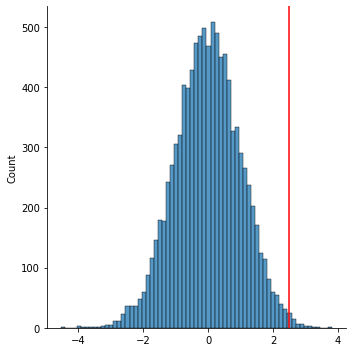

In [19]:
t_plot = sns.displot(samples)
t_plot.ax.axvline(t, color='red')

In [20]:
t, samples = bootstrap_samples(revenue_df, "variant", "conversion", 10_000, rng)

Mean A: 0.24317617866004962; Variance A: 0.18404152479234528
Mean B: 0.17733990147783252; Variance B: 0.1458904608216652
t-statistic: -3.259351782979207


In [21]:
1.0 - np.mean(samples > t)

0.00029999999999996696

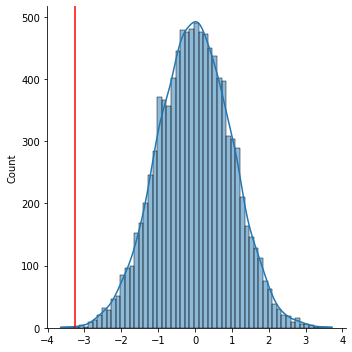

In [22]:
t_plot = sns.displot(samples, kde=True)
t_plot.ax.axvline(t, color='red')

## Mean revenue per user

In [23]:
mean_A = st.bootstrap(
    (revenue_df.loc[revenue_df["variant"] == "A", "revenue"].values,),
    np.mean,
    confidence_level=0.9,
    random_state=rng,
)


In [24]:
mean_A

BootstrapResult(confidence_interval=ConfidenceInterval(low=43.63466391222728, high=53.680890462684644), standard_error=3.030059342576033)

In [25]:
mean_B = st.bootstrap(
    (revenue_df.loc[revenue_df["variant"] == "B", "revenue"].values,),
    np.mean,
    confidence_level=0.9,
    random_state=rng,
)

In [26]:
mean_B

BootstrapResult(confidence_interval=ConfidenceInterval(low=55.05568817305396, high=70.53252835168765), standard_error=4.752606914300443)

## Conversion rates

In [27]:
mean_conv_A = st.bootstrap(
    (revenue_df.loc[revenue_df["variant"] == "A", "conversion"].values,),
    np.mean,
    confidence_level=0.9,
    random_state=rng,
)


In [28]:
mean_conv_A

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.21836228287841192, high=0.2679900744416873), standard_error=0.015089287665759038)

In [29]:
mean_conv_B = st.bootstrap(
    (revenue_df.loc[revenue_df["variant"] == "B", "conversion"].values,),
    np.mean,
    confidence_level=0.9,
    random_state=rng,
)

In [30]:
mean_conv_B

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.15517241379310345, high=0.19950738916256158), standard_error=0.013486131151355633)

## Tests

In [5]:
z_test_conversion(clean_logs, alternative="smaller")

--- Test for: Conversion ---
--- Method: Z-test ---

Expected downlift: 25.40%
P-value: 0.06%
Significant at 95%!
Significant at 99%!


In [6]:
bootstrap_pvalue(clean_logs, target_col="conversion", alternative="smaller")

--- Test for: Conversion ---
--- Method: Bootstrap resampling ---

Expected downlift: 25.40%
Mean A: 0.24
Mean B: 0.18
t-statistic: -3.26
P-value: 0.04%
Significant at 95%!
Significant at 99%!


In [7]:
bootstrap_pvalue(clean_logs, target_col="revenue", kpi_col="rpu", alternative="larger")

--- Test for: Revenue ---
--- Method: Bootstrap resampling ---

Expected uplift: 28.89%
Mean A: 48.45
Mean B: 62.45
t-statistic: 2.48
P-value: 0.59%
Significant at 95%!
Significant at 99%!


## Average booking revenue

In [53]:
mean_A = st.bootstrap(
    (
        revenue_df.loc[
            (revenue_df["variant"] == "A")
            & (revenue_df["revenue"] > 0)
            & (revenue_df["city"] == "london"),
            "revenue",
        ].values,
    ),
    np.mean,
    confidence_level=0.95,
    random_state=rng,
)

In [54]:
exp_a = (mean_A.confidence_interval.high + mean_A.confidence_interval.low) / 2

In [55]:
err_a = (mean_A.confidence_interval.high - mean_A.confidence_interval.low) / 2

In [56]:
mean_B = st.bootstrap(
    (
        revenue_df.loc[
            (revenue_df["variant"] == "B")
            & (revenue_df["revenue"] > 0)
            & (revenue_df["city"] == "london"),
            "revenue",
        ].values,
    ),
    np.mean,
    confidence_level=0.95,
    random_state=rng,
)

In [57]:
exp_b = (mean_B.confidence_interval.high + mean_B.confidence_interval.low) / 2

In [58]:
err_b = (mean_B.confidence_interval.high - mean_B.confidence_interval.low) / 2

In [59]:
rate = 100 * ((exp_b / exp_a) - 1)
rate

81.70900226843993

In [60]:
100*np.sqrt((err_a*exp_b/(exp_a**2))**2 + (err_b/exp_a)**2)

17.002406442866903

In [61]:
mean_B.confidence_interval.low/mean_A.confidence_interval.high - 1

0.5960966957565847

In [62]:
mean_B.confidence_interval.high/mean_A.confidence_interval.low - 1

1.074146942715017